# Finding Shaker table sync cues in ACC measurements from Equivitals

having issues with datetime 
https://pandas.pydata.org/docs/whatsnew/v2.2.0.html#datetimelike

https://github.com/pandas-dev/pandas/issues/52895
Work around for now: plt.plot(df.col_in_dt,df.col_signal)

For now, convert all datetimes to utc with .tz_localize(None), .dt.tz_localize(None), and custom remove_tz_from_dataframe function

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
%load_ext autoreload
%autoreload 1
%aimport qex
%aimport al

In [3]:
pip show pandas | grep Version

Version: 2.2.1
Note: you may need to restart the kernel to use updated packages.


In [4]:
%reload_ext autoreload

In [5]:
def remove_tz_from_dataframe(df_in):
    df = df_in.copy()
    col_times = [ col for col in df.columns if any([isinstance(x, pd.Timestamp) for x in df[col]])]
    for col in col_times:
        df[col] = pd.to_datetime(df[col],format='ISO8601') 
        df[col] = df[col].dt.tz_localize(None) 
    return df

def xcov(datax, datay,maxlag=10):
    # https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas
    rs = []
    for i in range(-maxlag,maxlag):
        rs.append(datax.corr(datay.shift(i)))
    return rs

In [6]:
def min_align(ACC,cue,prelim_synch_time,max_offs):   
    sampleshift_s = cue['sTime'].diff().median()
    sf = np.round(1/sampleshift_s)
    t_range = [cue['sTime'].iloc[0],cue['sTime'].iloc[-1]]
    c_type = 'taps'
    xrange = [pd.to_timedelta(t_range[0],unit = 's') + prelim_synch_time,
              pd.to_timedelta(t_range[1],unit = 's') + prelim_synch_time]
#     print(xrange)
    sig_sTime = cue['sTime'].values #np.linspace(t_range[0],t_range[1],sf*(t_range[1]-t_range[0]),endpoint=False)
    cue.loc[:,'dTime'] = pd.to_timedelta(sig_sTime,unit='s')+prelim_synch_time

    max_offs = 5
    X = al.dt_cut(ACC,'dev_dTime',xrange[0],xrange[1])
    sig_t = (X['dev_dTime'].dt.tz_localize(None) - prelim_synch_time.tz_localize(None)).dt.total_seconds()
    sig_v = X['signal']
    f = interpolate.interp1d(sig_t,sig_v,fill_value='extrapolate')
    new_sig = f(sig_sTime)
    signal = pd.DataFrame()
    signal.loc[:,'signal'] = new_sig
    signal.loc[signal['signal'].isna(),'signal'] = 0
    # scale signals a little 
    M = signal['signal'].quantile(0.998)
    signal.loc[:,'signal']  = signal['signal']/M
    signal.loc[signal['signal']>1,'signal'] = 1
    signal.loc[signal['signal']<0,'signal'] = 0
    signal.loc[:,'sTime'] = sig_sTime
    signal.loc[:,'dev_dTime'] = pd.to_timedelta(sig_sTime,unit='s')+prelim_synch_time.tz_localize(None)
    length = np.min([len(signal),len(cue)]) # they should match, but just in case

    xcorred = pd.DataFrame()
    max_offs = 5
    xcorred['shift_s'] = np.linspace(-max_offs,max_offs,int(2*max_offs*sf), endpoint=False) 
    xcorred['r'] = xcov(cue[c_type].iloc[:length], signal['signal'].iloc[:length],int(max_offs*sf))
    max_shift = xcorred.loc[xcorred['r'].argmax(),'shift_s']
    max_r = xcorred['r'].max()
    cue.loc[:,'dev_dTime'] = cue['dTime'] - pd.to_timedelta(max_shift,unit='s')

    fig, axes = plt.subplots(3,1,figsize=(12,4))
    ax =axes[0]
    cue.plot(x='sTime',y=c_type,ax=ax)
    signal.plot(x='sTime',y='signal',label='ACC',ax=ax)
    ax.set_title('ACC synch alignment')
    ax.set_ylabel('Unaligned')
    ax.legend()

    ax = axes[1]
    xcorred.plot(x='shift_s',y='r',ax=ax)
    ax.plot(max_shift,max_r,'ro')
    ax.set_ylim([0,1])
    ax.grid(True)
    ax.set_xticklabels('')

    ax = axes[2]
    ax.plot(cue['dev_dTime'],cue[c_type],label=c_type)
    ax.plot(signal['dev_dTime'],signal['signal'],label='ACC')
    ax.xaxis.set_tick_params(rotation=40)

    ax.grid(True)
    ax.set_title('shift '+ str(np.round(max_shift,3))+ ' s')
    ax.set_ylabel('Aligned')
    ax.set_xlabel('dev_Time')
    plt.show()

    cue_time = cue.loc[cue['peaks']==1,'dev_dTime'].iloc[0].tz_localize(None) 
    C_results = {'best_dt': cue_time,'best_s': max_shift,'best_r': max_r,'CCC':xcorred,'cue':cue,'signal':signal}
    return C_results

# Get the cues for Wednesday March 6th

In [15]:
synch_times = {}

In [16]:
cue_times = pd.read_csv('./outfiles/cue1_acc_20240306.csv',index_col = 0)
# cue2_acc_20240304.csv#SV alignment for beeps
cue_times['DateTime'] = pd.to_datetime(cue_times['DateTime'],format='ISO8601')
cue_times['S_AudioTime'] = np.round(cue_times.index,4)
Sync_Zero_Time_s = cue_times.loc[cue_times['peaks']==1,'S_AudioTime'].iloc[0]
Sync_Zero_Time_dt = cue_times.loc[cue_times['peaks']==1,'DateTime'].iloc[0].tz_localize(None) 
synch_times['cue1_20240306'] = Sync_Zero_Time_dt
cue_times['SyncTime'] = cue_times['S_AudioTime']-Sync_Zero_Time_s # zero on onset of first synch cue
peak_times = cue_times.loc[cue_times['peaks']==1,'SyncTime']
peak_times

429.968750    0.0000
431.648438    1.6796
433.441406    3.4726
435.062500    5.0937
Name: SyncTime, dtype: float64

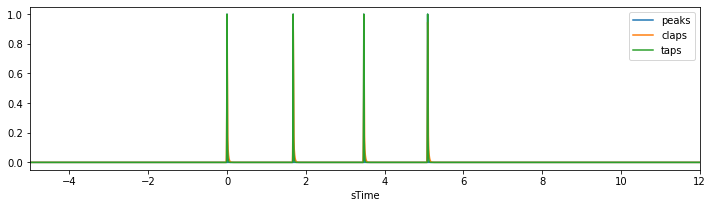

In [17]:
CueT={}
sf = 256
t_range= [-5,12]
cue = al.cue_template_make(peak_times,sf,t_range)
cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[12,3])
plt.xlim(t_range)

CueT['cue1_20240306'] = cue

In [18]:
Sync_Zero_Time_dt

Timestamp('2024-03-06 07:12:08')

In [19]:
synch_times

{'cue1_20240306': Timestamp('2024-03-06 07:12:08')}

In [20]:
CueT

{'cue1_20240306':           sTime  peaks           taps  claps
 0     -5.000000      0   0.000000e+00    0.0
 1     -4.996094      0   0.000000e+00    0.0
 2     -4.992188      0   0.000000e+00    0.0
 3     -4.988281      0   0.000000e+00    0.0
 4     -4.984375      0   0.000000e+00    0.0
 ...         ...    ...            ...    ...
 4347  11.980469      0  1.778608e-311    0.0
 4348  11.984375      0  1.185739e-311    0.0
 4349  11.988281      0  7.904925e-312    0.0
 4350  11.992188      0   0.000000e+00    0.0
 4351  11.996094      0   0.000000e+00    0.0
 
 [4352 rows x 4 columns]}

## Load example of ACC data

In [21]:
# note special complications: VN104 was not returned on march 04, recorded through to late on march 05
# LS404 was also late on March 05. These need to be synched with Synch 3. 

data_dir='/Volumes/TaeTae/Stavangar/20240307/Extracted SEM Data/'
sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(data_dir,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
df_datafiles.iloc[:5,:]
pid='VN101'
df_datafiles.loc[pid,:]

In [23]:
data_dir='/Volumes/Seagatehub/BiC2024/20240306/Equivital/Extracted SEM Data/'
sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(data_dir,projectName,sep)


In [24]:
df_datafiles.columns
df_datafiles

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
0,DATA,VN101,3420415,240306,0,DATA-VN101-3420415-24030600.CSV,csv,108868,2024-03-06 07:01:28+00:00,2024-03-06 12:18:58+00:00,...,[VN101],3420415.0,VN101,53.0,69,98.0,0.0,0.0,MovingSlowly,Upright
1,DATA,VN104,3420456,240306,101,DATA-VN104-3420456-24030600_0.CSV,csv,107663,2024-03-06 07:01:29+00:00,2024-03-06 12:17:59+00:00,...,[VN104],3420456.0,VN104,53.0,83,98.0,0.0,0.0,Stationary,Upright
2,DATA,VN105,3420755,240306,0,DATA-VN105-3420755-24030600.CSV,csv,107418,2024-03-06 07:01:31+00:00,2024-03-06 12:19:03+00:00,...,[VN105],3420755.0,VN105,53.0,0,98.0,0.0,0.0,Stationary,Upright
3,DATA,VN109,5022010,240306,0,DATA-VN109-5022010-24030600.CSV,csv,107678,2024-03-06 07:01:31+00:00,2024-03-06 12:19:01+00:00,...,[VN109],5022010.0,VN109,53.0,81,98.0,0.0,0.0,Stationary,Upright
4,DATA,VN110,5022026,240306,0,DATA-VN110-5022026-24030600.CSV,csv,107918,2024-03-06 07:01:35+00:00,2024-03-06 12:19:05+00:00,...,[VN110],5022026.0,VN110,53.0,79,98.0,0.0,0.0,Stationary,Upright
5,DATA,VN111,5022027,240306,0,DATA-VN111-5022027-24030600.CSV,csv,107913,2024-03-06 07:01:35+00:00,2024-03-06 12:18:20+00:00,...,[VN111],5022027.0,VN111,53.0,80,95.0,0.0,0.0,Stationary,Upright
6,DATA,VN206,5022062,240306,0,DATA-VN206-5022062-24030600.CSV,csv,107062,2024-03-06 07:02:53+00:00,2024-03-06 12:17:53+00:00,...,[VN206],5022062.0,VN206,53.0,66,99.0,0.0,0.0,Stationary,Upright
7,DATA,VN201,5022050,240306,0,DATA-VN201-5022050-24030600.CSV,csv,107890,2024-03-06 07:02:53+00:00,2024-03-06 12:20:08+00:00,...,[VN201],5022050.0,VN201,53.0,75,97.0,0.0,0.0,Stationary,Upright
8,DATA,VN211,5022247,240306,0,DATA-VN211-5022247-24030600.CSV,csv,107380,2024-03-06 07:02:55+00:00,2024-03-06 12:18:40+00:00,...,[VN211],5022247.0,VN211,53.0,77,97.0,0.0,0.0,Stationary,Upright
9,DATA,VN212,5022256,240306,0,DATA-VN212-5022256-24030600.CSV,csv,106953,2024-03-06 07:02:55+00:00,2024-03-06 12:17:55+00:00,...,[VN212],5022256.0,VN212,53.0,68,98.0,0.0,0.0,Stationary,Upright


In [42]:
df_datafiles.iloc[:5,:]
pid='PC709'
df_datafiles.loc[pid,:]

Signal                                                            DATA
ID                                                             5022299
Date                                                            240304
Session                                                              1
FileName                               DATA-PC709-5022299-24030401.CSV
FileType                                                           csv
FileSize                                                        139717
RecStart                                           2024-03-04 07:52:15
FullLoc              /Volumes/Seagatehub/BiC2024/20240304/Equivital...
DATAloc              /Volumes/Seagatehub/BiC2024/20240304/Equivital...
ACCloc               /Volumes/Seagatehub/BiC2024/20240304/Equivital...
RESPloc              /Volumes/Seagatehub/BiC2024/20240304/Equivital...
RRloc                /Volumes/Seagatehub/BiC2024/20240304/Equivital...
ECGloc               /Volumes/Seagatehub/BiC2024/20240304/Equivital...
RecEnd

In [43]:
V = pd.read_csv(df_datafiles.loc[pid,'ACCloc'],skipinitialspace=True)
# V = pd.read_csv('./testing/FASTACC-BR604-5022198-24030700.CSV',skipinitialspace=True)

ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime'])
df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))
ACC = remove_tz_from_dataframe(ACC)
ACC.loc[:5,:]

,dev_dTime,signal
0,2024-03-04 07:51:47.007,0.0
1,2024-03-04 07:51:47.011,0.0
2,2024-03-04 07:51:47.015,0.0
3,2024-03-04 07:51:47.019,0.0
4,2024-03-04 07:51:47.023,0.0
5,2024-03-04 07:51:47.027,0.0


In [44]:
c = 'cue1_20240304'

In [45]:
synch_times[c]

Timestamp('2024-03-04 07:56:23.762800')

15360


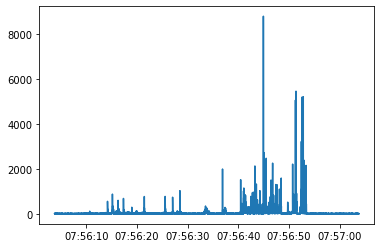

In [46]:
dt_0 = synch_times[c]-pd.to_timedelta(20,unit='s')
dt_1 = synch_times[c]+pd.to_timedelta(40,unit='s')
ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
print(len(ACC_ex))
plt.plot(ACC_ex['dev_dTime'],ACC_ex['signal'])

In [111]:
# it seems the clocks on the equivitals are nearly 30 s of from the time selected in the cue findings. 
# We can fix this in TimeAlign/Shake_Audio_Cue.ipynb

c = 'cue1_20240304'
cue = CueT[c].copy()
prelim_synch_time = (synch_times[c]+pd.to_timedelta(0,unit='s')).tz_localize(None)
print(prelim_synch_time)
cue

2024-03-04 07:56:23.762800


,sTime,peaks,taps,claps
0,-5.000000,0,0.000000e+00,0.0
1,-4.996094,0,0.000000e+00,0.0
2,-4.992188,0,0.000000e+00,0.0
3,-4.988281,0,0.000000e+00,0.0
4,-4.984375,0,0.000000e+00,0.0
...,...,...,...,...
4347,11.980469,0,9.881313e-324,0.0
4348,11.984375,0,9.881313e-324,0.0
4349,11.988281,0,9.881313e-324,0.0
4350,11.992188,0,0.000000e+00,0.0


In [112]:
sampleshift_s = cue['sTime'].diff().median()
sf = np.round(1/sampleshift_s)
t_range = [cue['sTime'].iloc[0],cue['sTime'].iloc[-1]]
c_type = 'taps'
xrange = [pd.to_timedelta(t_range[0],unit = 's') + prelim_synch_time,
          pd.to_timedelta(t_range[1],unit = 's') + prelim_synch_time]
sig_sTime = cue['sTime'].values #np.linspace(t_range[0],t_range[1],sf*(t_range[1]-t_range[0]),endpoint=False)
cue.loc[:,'dTime'] = pd.to_timedelta(sig_sTime,unit='s')+prelim_synch_time

max_offs = 5
X = al.dt_cut(ACC,'dev_dTime',xrange[0],xrange[1])
sig_t = (X['dev_dTime'].dt.tz_localize(None) - prelim_synch_time.tz_localize(None)).dt.total_seconds()
sig_v = X['signal']
f = interpolate.interp1d(sig_t,sig_v,fill_value='extrapolate')
new_sig = f(sig_sTime)
signal = pd.DataFrame()
signal.loc[:,'signal'] = new_sig
signal.loc[signal['signal'].isna(),'signal'] = 0
# scale signals a little 
M = signal['signal'].quantile(0.998)
signal.loc[:,'signal']  = signal['signal']/M
signal.loc[signal['signal']>1,'signal'] = 1
signal.loc[signal['signal']<0,'signal'] = 0
signal.loc[:,'sTime'] = sig_sTime
signal.loc[:,'dev_dTime'] = pd.to_timedelta(sig_sTime,unit='s')+prelim_synch_time.tz_localize(None)
length = np.min([len(signal),len(cue)]) # they should match, but just in case
# plt.plot(cue['dTime'],cue['taps'])

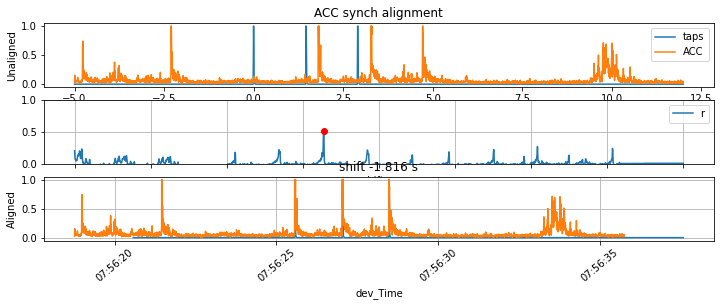

2024-03-04 07:56:25.579206250


In [113]:
xcorred = pd.DataFrame()
max_offs = 10
xcorred['shift_s'] = np.linspace(-max_offs,max_offs,int(2*max_offs*sf), endpoint=False) 
xcorred['r'] = xcov(cue[c_type].iloc[:length], signal['signal'].iloc[:length],int(max_offs*sf))
max_shift = xcorred.loc[xcorred['r'].argmax(),'shift_s']
max_r = xcorred['r'].max()
cue.loc[:,'dev_dTime'] = cue['dTime'] - pd.to_timedelta(max_shift,unit='s')

fig, axes = plt.subplots(3,1,figsize=(12,4))
ax =axes[0]
cue.plot(x='sTime',y=c_type,ax=ax)
signal.plot(x='sTime',y='signal',label='ACC',ax=ax)
ax.set_title('ACC synch alignment')
ax.set_ylabel('Unaligned')
ax.legend()

ax = axes[1]
xcorred.plot(x='shift_s',y='r',ax=ax)
ax.plot(max_shift,max_r,'ro')
ax.set_ylim([0,1])
ax.grid(True)
ax.set_xticklabels('')

ax = axes[2]
ax.plot(cue['dev_dTime'],cue[c_type],label=c_type)
ax.plot(signal['dev_dTime'],signal['signal'],label='ACC')
ax.xaxis.set_tick_params(rotation=40)

ax.grid(True)
ax.set_title('shift '+ str(np.round(max_shift,3))+ ' s')
ax.set_ylabel('Aligned')
ax.set_xlabel('dev_Time')
plt.show()

cue_time = cue.loc[cue['peaks']==1,'dev_dTime'].iloc[0].tz_localize(None) 
C_results = {'best': cue_time,'CCC':xcorred,'cue':cue,'signal':signal}
print(cue_time)

In [114]:
synch_times[c] # 2024-03-04 07:56:25.579206250

Timestamp('2024-03-04 07:56:23.762800')

In [115]:
ACC.iloc[-5:,:]

,dev_dTime,signal
6380534,2024-03-04 14:47:10.980,27.129320
6380535,2024-03-04 14:47:10.984,54.000000
6380536,2024-03-04 14:47:10.988,24.186773
6380537,2024-03-04 14:47:10.992,33.241540
6380538,2024-03-04 14:47:10.996,16.000000


In [116]:
dt_0 

Timestamp('2024-03-04 07:56:03.762800')

In [117]:
CueT[c]

,sTime,peaks,taps,claps
0,-5.000000,0,0.000000e+00,0.0
1,-4.996094,0,0.000000e+00,0.0
2,-4.992188,0,0.000000e+00,0.0
3,-4.988281,0,0.000000e+00,0.0
4,-4.984375,0,0.000000e+00,0.0
...,...,...,...,...
4347,11.980469,0,9.881313e-324,0.0
4348,11.984375,0,9.881313e-324,0.0
4349,11.988281,0,9.881313e-324,0.0
4350,11.992188,0,0.000000e+00,0.0


In [118]:
synch_times['cue2_20240304']

Timestamp('2024-03-04 14:25:45.200000')

In [120]:
c = 'cue2_20240304'
dt_0 = synch_times[c]-pd.to_timedelta(20,unit='s')
dt_1 = synch_times[c]+pd.to_timedelta(40,unit='s')
ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
ACC_ex

,dev_dTime,signal
6046255,2024-03-04 14:25:25.203,11.357817
6046256,2024-03-04 14:25:25.207,6.928203
6046257,2024-03-04 14:25:25.211,5.656854
6046258,2024-03-04 14:25:25.215,5.656854
6046259,2024-03-04 14:25:25.219,8.944272
...,...,...
6061610,2024-03-04 14:26:25.184,20.223748
6061611,2024-03-04 14:26:25.188,21.000000
6061612,2024-03-04 14:26:25.191,12.649111
6061613,2024-03-04 14:26:25.195,55.803226


In [121]:
CueT[c]

,sTime,peaks,taps,claps
0,23354.980500,0,0.000000e+00,0.0
1,23354.984406,0,0.000000e+00,0.0
2,23354.988312,0,0.000000e+00,0.0
3,23354.992219,0,0.000000e+00,0.0
4,23354.996125,0,0.000000e+00,0.0
...,...,...,...,...
4347,23371.960969,0,8.059824e-234,0.0
4348,23371.964875,0,5.373216e-234,0.0
4349,23371.968781,0,3.582144e-234,0.0
4350,23371.972687,0,0.000000e+00,0.0


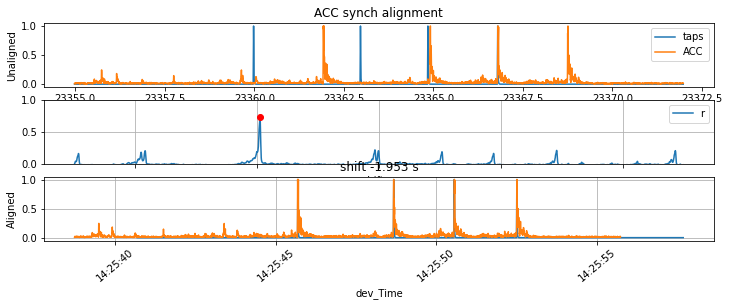

Timestamp('2024-03-04 14:25:45.696425')

In [122]:
c = 'cue2_20240304'
results = min_align(ACC,CueT[c].copy(),prelim_synch_time,10)
results['best_dt']

In [ ]:
2024-03-04 07:56:25.579206250
        2024-03-04 14:25:45.696425'

# Running through the sensors

['VA302', 23.574415922164917]


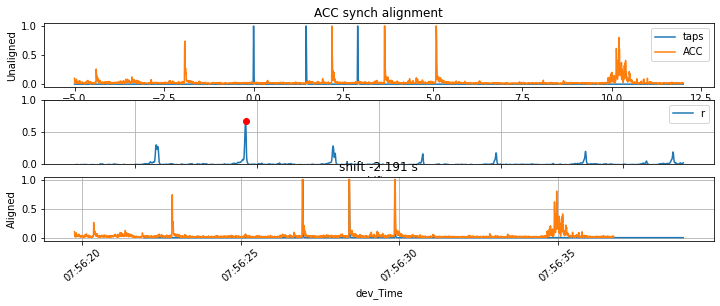

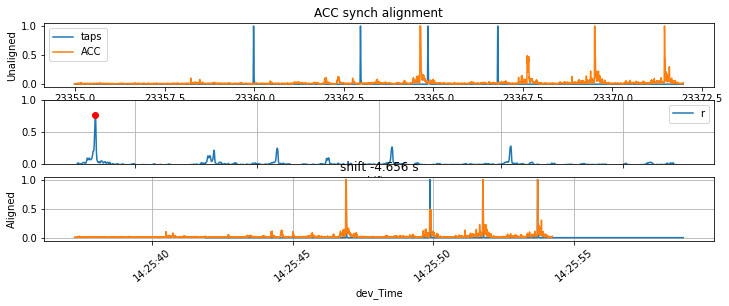

['PC702', 49.53964185714722]


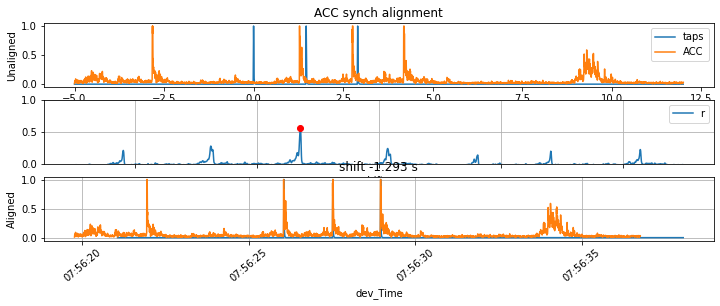

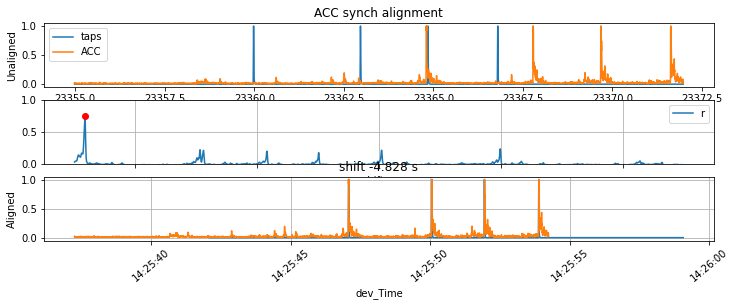

['PC705', 76.65477991104126]


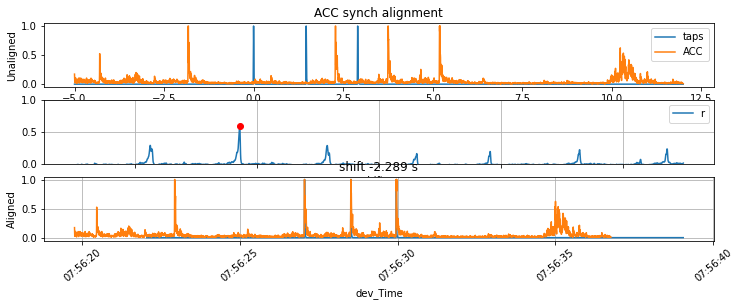

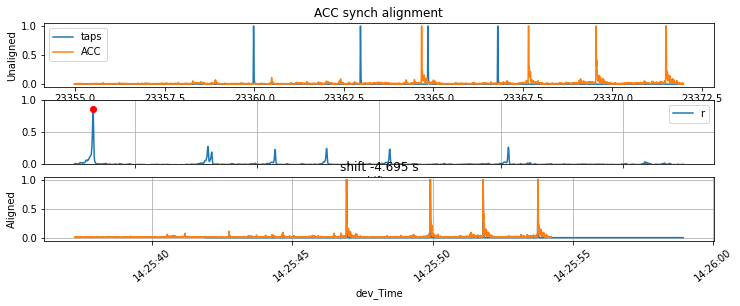

78.89918184280396


,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r
SUBJECT ID,,,,,,
BLUETOOTH01,NaN,NaN,NaN,NaN,NaN,NaN
BLUETOOTH04,NaN,NaN,NaN,NaN,NaN,NaN
BLUETOOTH03,NaN,NaN,NaN,NaN,NaN,NaN
VN101,2024-03-04 07:56:25.407331250,-1.644531,0.489273,2024-03-04 14:25:43.633925,0.109375,0.682468
VN102,2024-03-04 07:56:25.383893750,-1.621094,0.495585,2024-03-04 14:25:44.051893750,-0.308594,0.707907
...,...,...,...,...,...,...
PC702,2024-03-04 07:56:26.055768750,-1.292969,0.555586,2024-03-04 14:25:47.071425,-2.328125,0.749781
PC703,2024-03-04 07:56:25.282331250,-1.519531,0.576534,2024-03-04 14:25:45.321425,-1.578125,0.802204
PC704,2024-03-04 07:56:25.790143750,-2.027344,0.57541,2024-03-04 14:25:45.973768750,-2.230469,0.802896


In [126]:
# df_shifts = pd.DataFrame(index = df_datafiles.index,columns = ['Cue1_devdTime','Cue1_s','Cue1_r','Cue2_devdTime','Cue2_s','Cue2_r'])
tic = time.time()
t_center = 1
t_drift = 2.5

for pid,row in df_datafiles.iterrows():
    if pid in ['VA302','PC702','PC705']:
#     if pid not in ['BLUETOOTH01','BLUETOOTH02','BLUETOOTH03','BLUETOOTH04']:
        V = pd.read_csv(df_datafiles.loc[pid,'ACCloc'],skipinitialspace=True)
        ACC = pd.DataFrame()
        ACC['dev_dTime'] = pd.to_datetime(V['DateTime'])
        df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
        ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))
        ACC = remove_tz_from_dataframe(ACC)
        print([pid,time.time()-tic])

        dt_0 = synch_times['cue1_20240304']-pd.to_timedelta(25,unit='s')
        dt_1 = synch_times['cue1_20240304']+pd.to_timedelta(25,unit='s')
        ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
        maxlag_s = 5
        results = min_align(ACC_ex,CueT['cue1_20240304'].copy(),(synch_times['cue1_20240304']+pd.to_timedelta(t_center,unit='s')).tz_localize(None),maxlag_s)
        df_shifts.loc[pid,'Cue1_devdTime'] = results['best_dt']
        df_shifts.loc[pid,'Cue1_s'] = results['best_s']
        df_shifts.loc[pid,'Cue1_r'] = results['best_r']

        dt_0 = synch_times['cue2_20240304']-pd.to_timedelta(25,unit='s')
        dt_1 = synch_times['cue2_20240304']+pd.to_timedelta(25,unit='s')
        ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
        maxlag_s = 10
        results = min_align(ACC_ex,CueT['cue2_20240304'].copy(),(synch_times['cue1_20240304']+pd.to_timedelta(t_center-t_drift,unit='s')).tz_localize(None),maxlag_s)
        df_shifts.loc[pid,'Cue2_devdTime'] = results['best_dt']
        df_shifts.loc[pid,'Cue2_s'] = results['best_s']+t_drift
        df_shifts.loc[pid,'Cue2_r'] = results['best_r']
    
print(time.time()-tic)
df_shifts

In [127]:
[df_shifts['Cue1_s'].mean(),df_shifts['Cue2_s'].mean()]

[-2.021515376984127, -1.9070560515873016]

In [128]:
df_shifts['dur_dt']=pd.to_datetime(df_shifts['Cue2_devdTime'])-pd.to_datetime(df_shifts['Cue1_devdTime'])
df_shifts['dur_s']=df_shifts['dur_dt'].dt.total_seconds() #pd.to_datetime(cue_times['DateTime'],format='ISO8601')

In [130]:
(synch_times['cue2_20240304']-synch_times['cue1_20240304']).total_seconds()

23361.4372

In [131]:
df_shifts['devID'] = df_datafiles['ID']

In [132]:
df_shifts

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,devID
SUBJECT ID,,,,,,,,,
BLUETOOTH01,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,5022281
BLUETOOTH04,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,5022297
BLUETOOTH03,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,5022292
VN101,2024-03-04 07:56:25.407331250,-1.644531,0.489273,2024-03-04 14:25:43.633925,0.109375,0.682468,0 days 06:29:18.226593750,23358.226594,3420415
VN102,2024-03-04 07:56:25.383893750,-1.621094,0.495585,2024-03-04 14:25:44.051893750,-0.308594,0.707907,0 days 06:29:18.668000,23358.668000,3420426
...,...,...,...,...,...,...,...,...,...
PC702,2024-03-04 07:56:26.055768750,-1.292969,0.555586,2024-03-04 14:25:47.071425,-2.328125,0.749781,0 days 06:29:21.015656250,23361.015656,5022240
PC703,2024-03-04 07:56:25.282331250,-1.519531,0.576534,2024-03-04 14:25:45.321425,-1.578125,0.802204,0 days 06:29:20.039093750,23360.039094,5022241
PC704,2024-03-04 07:56:25.790143750,-2.027344,0.57541,2024-03-04 14:25:45.973768750,-2.230469,0.802896,0 days 06:29:20.183625,23360.183625,5022244


In [133]:
cues_delta = (synch_times['cue2_20240304']-synch_times['cue1_20240304']).total_seconds()
df_shifts['drift_s'] = df_shifts['dur_s']-cues_delta 
df_shifts['drift_rate_sphr']=(df_shifts['drift_s'])/(cues_delta/3600)
# drifted seconds per hour
df_shifts['drift_rate_sphr']

SUBJECT ID
BLUETOOTH01         NaN
BLUETOOTH04         NaN
BLUETOOTH03         NaN
VN101         -0.494755
VN102         -0.426734
                 ...   
PC702         -0.064960
PC703         -0.215448
PC704         -0.193176
PC705         -0.238925
PC709         -0.203409
Name: drift_rate_sphr, Length: 67, dtype: float64

In [135]:
df_shifts['devID'] = df_datafiles['ID']
df_shifts['ACCFile'] = df_datafiles['ACCloc']
df_shifts['Cue1_file'] = './outfiles/cue1_acc_20240304.csv'
df_shifts['Cue1_name'] = 'cue1_20240304'
df_shifts['Cue1_dt'] = synch_times['cue1_20240304']
df_shifts['Cue2_file'] = './outfiles/cue2_acc_20240304.csv'
df_shifts['Cue2_name'] = 'cue2_20240304'
df_shifts['Cue2_dt'] = synch_times['cue2_20240304']
df_shifts

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,devID,drift_s,drift_rate_sphr,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt
SUBJECT ID,,,,,,,,,,,,,,,,,,
BLUETOOTH01,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,5022281,NaN,NaN,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
BLUETOOTH04,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,5022297,NaN,NaN,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
BLUETOOTH03,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,5022292,NaN,NaN,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
VN101,2024-03-04 07:56:25.407331250,-1.644531,0.489273,2024-03-04 14:25:43.633925,0.109375,0.682468,0 days 06:29:18.226593750,23358.226594,3420415,-3.210606,-0.494755,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
VN102,2024-03-04 07:56:25.383893750,-1.621094,0.495585,2024-03-04 14:25:44.051893750,-0.308594,0.707907,0 days 06:29:18.668000,23358.668000,3420426,-2.769200,-0.426734,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC702,2024-03-04 07:56:26.055768750,-1.292969,0.555586,2024-03-04 14:25:47.071425,-2.328125,0.749781,0 days 06:29:21.015656250,23361.015656,5022240,-0.421544,-0.064960,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
PC703,2024-03-04 07:56:25.282331250,-1.519531,0.576534,2024-03-04 14:25:45.321425,-1.578125,0.802204,0 days 06:29:20.039093750,23360.039094,5022241,-1.398106,-0.215448,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
PC704,2024-03-04 07:56:25.790143750,-2.027344,0.57541,2024-03-04 14:25:45.973768750,-2.230469,0.802896,0 days 06:29:20.183625,23360.183625,5022244,-1.253575,-0.193176,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200


In [136]:
df_shifts.to_csv('./outfiles/Cue_ACC_dev_align_20240304.csv')
df_shifts

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,devID,drift_s,drift_rate_sphr,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt
SUBJECT ID,,,,,,,,,,,,,,,,,,
BLUETOOTH01,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,5022281,NaN,NaN,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
BLUETOOTH04,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,5022297,NaN,NaN,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
BLUETOOTH03,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,5022292,NaN,NaN,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
VN101,2024-03-04 07:56:25.407331250,-1.644531,0.489273,2024-03-04 14:25:43.633925,0.109375,0.682468,0 days 06:29:18.226593750,23358.226594,3420415,-3.210606,-0.494755,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
VN102,2024-03-04 07:56:25.383893750,-1.621094,0.495585,2024-03-04 14:25:44.051893750,-0.308594,0.707907,0 days 06:29:18.668000,23358.668000,3420426,-2.769200,-0.426734,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC702,2024-03-04 07:56:26.055768750,-1.292969,0.555586,2024-03-04 14:25:47.071425,-2.328125,0.749781,0 days 06:29:21.015656250,23361.015656,5022240,-0.421544,-0.064960,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
PC703,2024-03-04 07:56:25.282331250,-1.519531,0.576534,2024-03-04 14:25:45.321425,-1.578125,0.802204,0 days 06:29:20.039093750,23360.039094,5022241,-1.398106,-0.215448,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
PC704,2024-03-04 07:56:25.790143750,-2.027344,0.57541,2024-03-04 14:25:45.973768750,-2.230469,0.802896,0 days 06:29:20.183625,23360.183625,5022244,-1.253575,-0.193176,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
